# **PEPPA DataSet**

## Import the necessary libraries

In [22]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from typing import *

Ref = cv.imread('./Dataset/Peppa/peppa.png')  
Pz1 = cv.imread('./Dataset/Peppa/pieces1.png')  
Pz2 = cv.imread('./Dataset/Peppa/pieces2.png')  

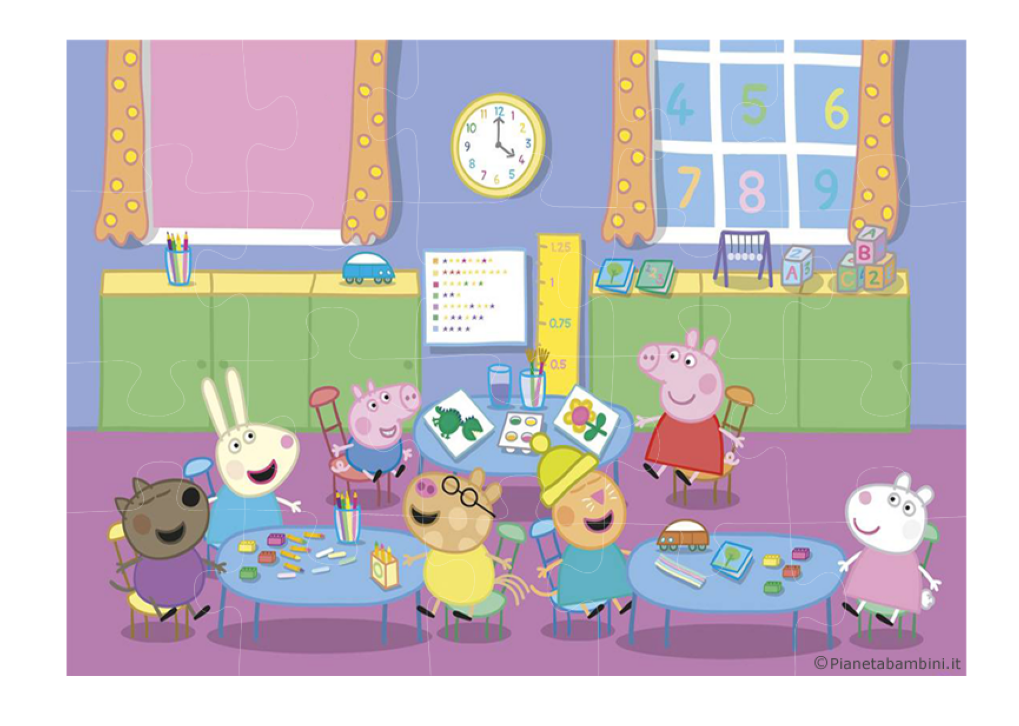

In [23]:
# Func to Show Images using Matplotlib
def ImShow(Im:np.ndarray, FigSize:tuple = (10, 8)) -> None:

    if len(Im.shape) == 3 and Im.shape[2] == 3:
        Im = cv.cvtColor(Im, cv.COLOR_BGR2RGB)
    else:
        Im = cv.cvtColor(Im, cv.COLOR_GRAY2RGB)

    plt.figure(figsize=FigSize)
    plt.imshow(Im)
    plt.axis("off")
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.margins(0, 0)
    plt.show()
    
# Example Usage
ImShow(Ref)

In [24]:
# Func to Plot an Image Grid
def PlotImageGrid(ImageList: list, Rows: int, Cols: int, FigSize: tuple = (20, 16)) -> None:
    plt.figure(figsize=FigSize)
    for idx, Image in enumerate(ImageList):
        if len(Image.shape) == 3 and Image.shape[2] == 3:
            Image = cv.cvtColor(Image, cv.COLOR_BGR2RGB)
        else:
            Image = cv.cvtColor(Image, cv.COLOR_GRAY2BGR)

        plt.subplot(Rows, Cols, idx + 1)
        plt.imshow(Image)
        plt.axis("off")
        plt.subplots_adjust(wspace=0.0, hspace=0.0)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.margins(0, 0)

    Canvas = plt.get_current_fig_manager().canvas
    plt.close()
    Canvas.draw()
    PlotImage = np.frombuffer(Canvas.buffer_rgba(), dtype=np.uint8)
    PlotImage = PlotImage.reshape(Canvas.get_width_height()[::-1] + (4,))
    PlotImage = cv.cvtColor(PlotImage, cv.COLOR_RGB2BGR)

    ImShow(PlotImage, FigSize=FigSize)

In [25]:
# Func to Apply HSV Filter
def ApplyHSVFilter(Im:np.ndarray, Filter:dict) -> Tuple[np.ndarray, np.ndarray]:

    Lower = [Filter["HMin"], Filter["SMin"], Filter["VMin"]]
    Upper = [Filter["HMax"], Filter["SMax"], Filter["VMax"]]
    FilterType = Filter["FilterType"]

    HSV = cv.cvtColor(Im, cv.COLOR_BGR2HSV)
    Msk = cv.inRange(HSV, np.array(Lower), np.array(Upper))
    if FilterType == "Inv Bin": Msk = cv.bitwise_not(Msk)

    return cv.bitwise_and(Im, Im, mask=Msk), Msk

## Segmentation

Pieces Found: 10
Pieces Found: 10


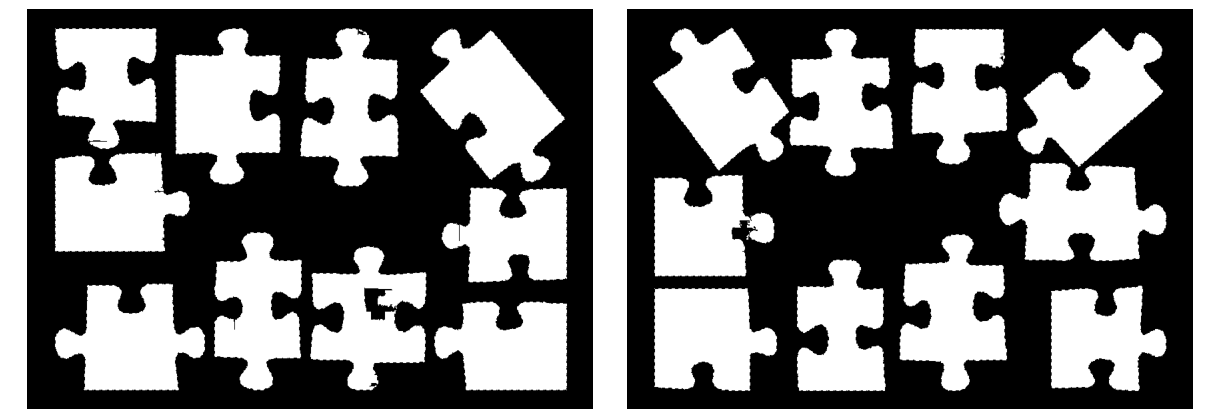

In [26]:
# Create Filters to Separate the BackGround
Filt = {'HMin': 0, 'SMin': 0, 'VMin': 254, 'HMax': 1, 'SMax': 1, 'VMax': 255, 'FilterType': 'Inv Bin'}

# Filter Pieces
_, PieceMask1 = ApplyHSVFilter(Pz1, Filt)
_, PieceMask2 = ApplyHSVFilter(Pz2, Filt)

# Apply Area Size Filter
MinArea = 5000  # in Pixels
PuzzleMasks = []
for PieceMask in [PieceMask1, PieceMask2]:
    contours, _ = cv.findContours(PieceMask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    PieceMask = np.zeros_like(PieceMask)
    Cnt = 0
    for cnt in contours:
        area = cv.contourArea(cnt)
        if area > MinArea:
            cv.drawContours(PieceMask, [cnt], -1, (255, 255, 255), -1)
            Cnt += 1

    PuzzleMasks.append(PieceMask)
    print(f"Pieces Found: {Cnt}")


PlotImageGrid(PuzzleMasks, 1, 2, (12, 4))

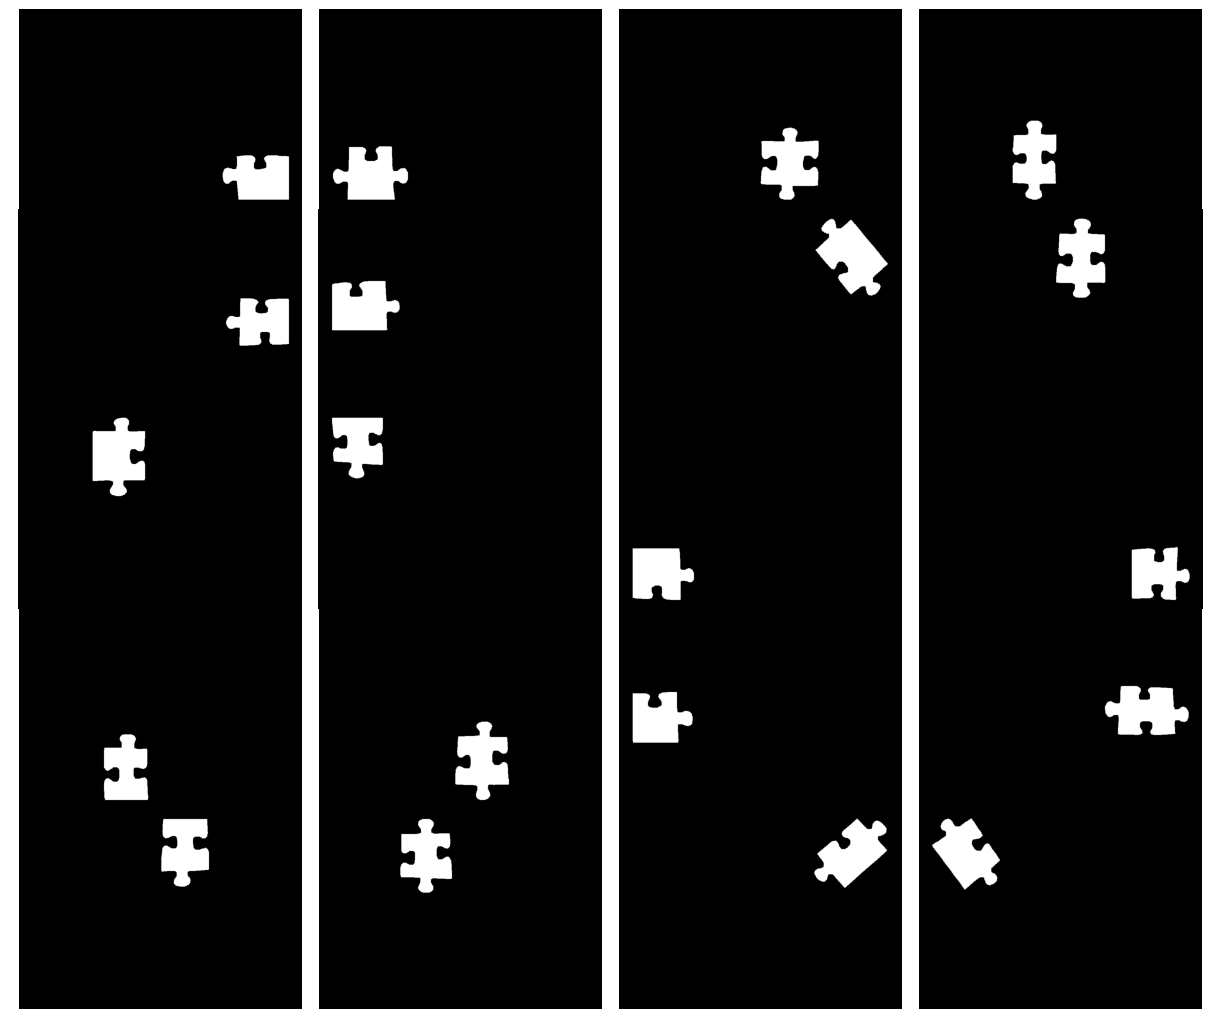

In [27]:
# Separate Segments and Apply Filter to Make Perfect Mask for Pieces
BorderPixels = 6
Masks = []
for PieceMask in PuzzleMasks:
    # Get the Contours
    Cnts, _ = cv.findContours(PieceMask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Separate Pieces in Their Bounding Rectangle
    MaskPieces = []
    for j, Cnt in enumerate(Cnts):

        # Modify the Mask to Only Keep this Contour
        Piece = np.zeros_like(PieceMask)
        cv.drawContours(Piece, [Cnt], -1, (255, 255, 255), -1)

        # Filter1: Only Keep the Biggest Contour
        TmpCnts, _ = cv.findContours(Piece, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        TmpCnts = sorted(TmpCnts, key=cv.contourArea, reverse=True)
        Piece = np.zeros_like(Piece)
        cv.drawContours(Piece, [TmpCnts[0]], -1, (255, 255, 255), -1)

        # Filter2: Fill the Cavities Inside the Pieces
        Kernel = np.ones((11, 11), np.uint8)
        Piece = cv.morphologyEx(Piece, cv.MORPH_CLOSE, Kernel)

        PieceFilled = Piece.copy()
        h, w = PieceFilled.shape[:2]

        # Find Suitable Seed for FloodFill
        Seed = None
        for SourceY in range(PieceFilled.shape[0]):
            for SourceX in range(PieceFilled.shape[1]):
                if PieceFilled[SourceY, SourceX] == 0:
                    Seed = (SourceX, SourceY)
                    break
            if Seed:
                break

        # FloodFill if a Seed Point is Found
        if Seed is not None:
            mask = np.zeros((h+2, w+2), np.uint8)
            cv.floodFill(PieceFilled, mask, Seed, 255)

            InvFilled = cv.bitwise_not(PieceFilled)
            Piece = Piece | InvFilled

        # Save the Piece
        MaskPieces.append(Piece)
        
    Masks += MaskPieces

PlotImageGrid(Masks, 5, 4, (12, 10))

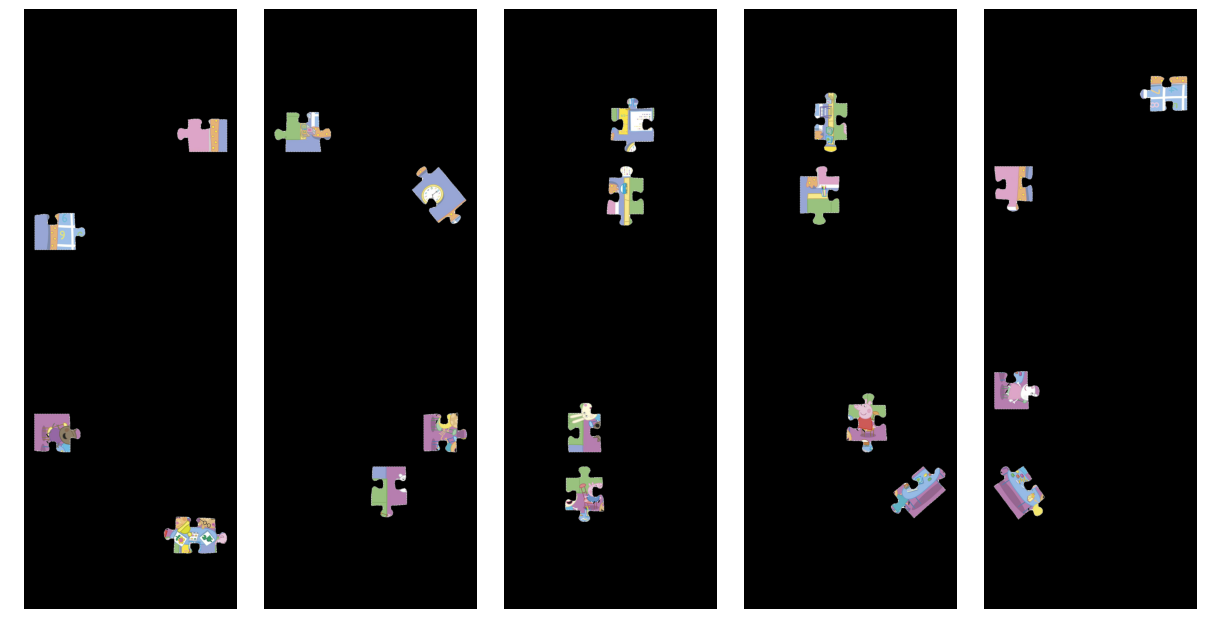

In [28]:
# Apply the Masks to Get the Pieces
Pieces = []
for i in range(len(Masks)):
    RawPuzzle = Pz1 if i < (len(Masks) // 2) else Pz2
    Pieces.append(cv.bitwise_and(RawPuzzle, RawPuzzle, mask=Masks[i]))

PlotImageGrid(Pieces, 4, 5, (12, 6))

## Matching

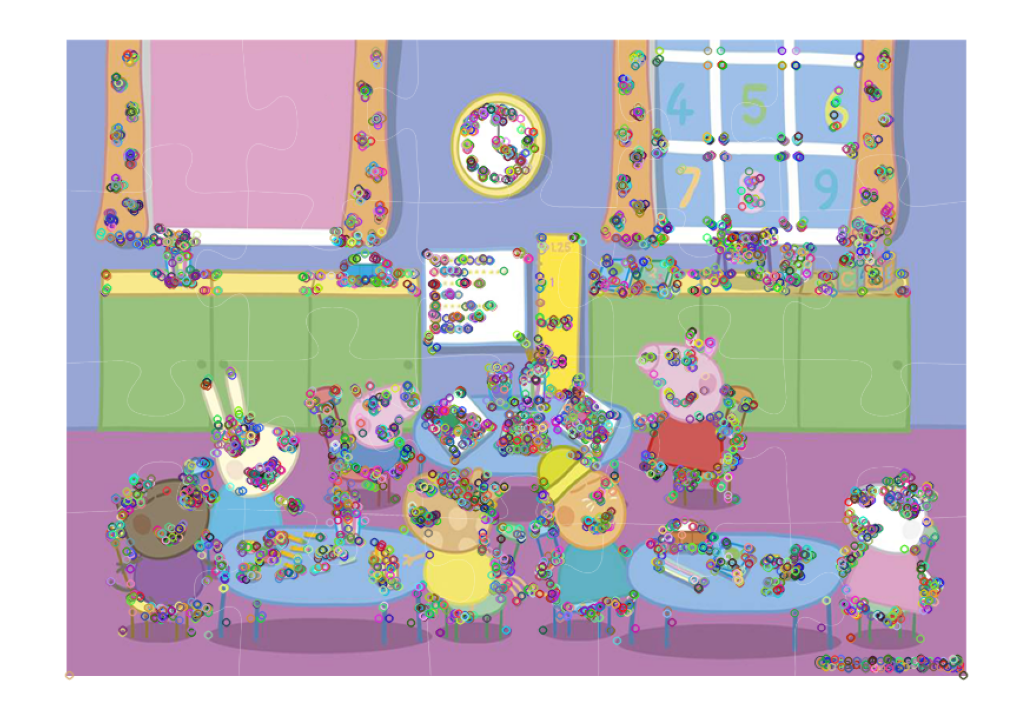

In [29]:
# Create the ORB Obj
ORB = cv.ORB_create(nfeatures=7000)

# Finds the Keypoints and Descriptors for the Reference Image
GrayRef = cv.cvtColor(Ref, cv.COLOR_BGR2GRAY)
RefKeyPoints, RefDescr = ORB.detectAndCompute(GrayRef, None)

# Draw Keypoints on the Reference Image
RefDrawnKP = cv.drawKeypoints(Ref, RefKeyPoints, None)
ImShow(RefDrawnKP)

# Finds the Keypoints and Descriptors
PiecesKP = []
PiecesDescr = []
PiecesWithFeatures = []
for i, piece in enumerate(Pieces):
    keypoints, descriptors = ORB.detectAndCompute(piece, None)
    PiecesKP.append(keypoints)
    PiecesDescr.append(descriptors)

# Finds the Correspondences Between the Image Descriptors and the Piece Descr
Ratio = 3
Matches = []
for i, PDescr in enumerate(PiecesDescr): 
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    PieceMtch = bf.match(PDescr, RefDescr)

    # Discard Zeros
    FilteredMatches = [m for m in PieceMtch if m.distance > 0]
    
    # Refines the Matches
    MinDist = min([m.distance for m in FilteredMatches])
    RefinedMatches = [m for m in PieceMtch if m.distance < Ratio * MinDist]
    Matches.append(RefinedMatches)

# Find the affine transformation using the refined matches
AffineTransforms = []
for i, RefinedMatches in enumerate(Matches):
    if len(RefinedMatches) >= 3:
        PieceP = np.float32([PiecesKP[i][m.queryIdx].pt for m in RefinedMatches]).reshape(-1, 1, 2)
        RefP   = np.float32([RefKeyPoints[m.trainIdx].pt for m in RefinedMatches]).reshape(-1, 1, 2)
        
        Trns = cv.estimateAffinePartial2D(PieceP, RefP)[0]
        AffineTransforms.append(Trns)

        if Trns is None: print(f"No valid transformation found for piece {i + 1}")
    
    else:
        print(f"Not enough matches for piece {i + 1} to compute affine transformation.")


## Puzzle Reconstruction

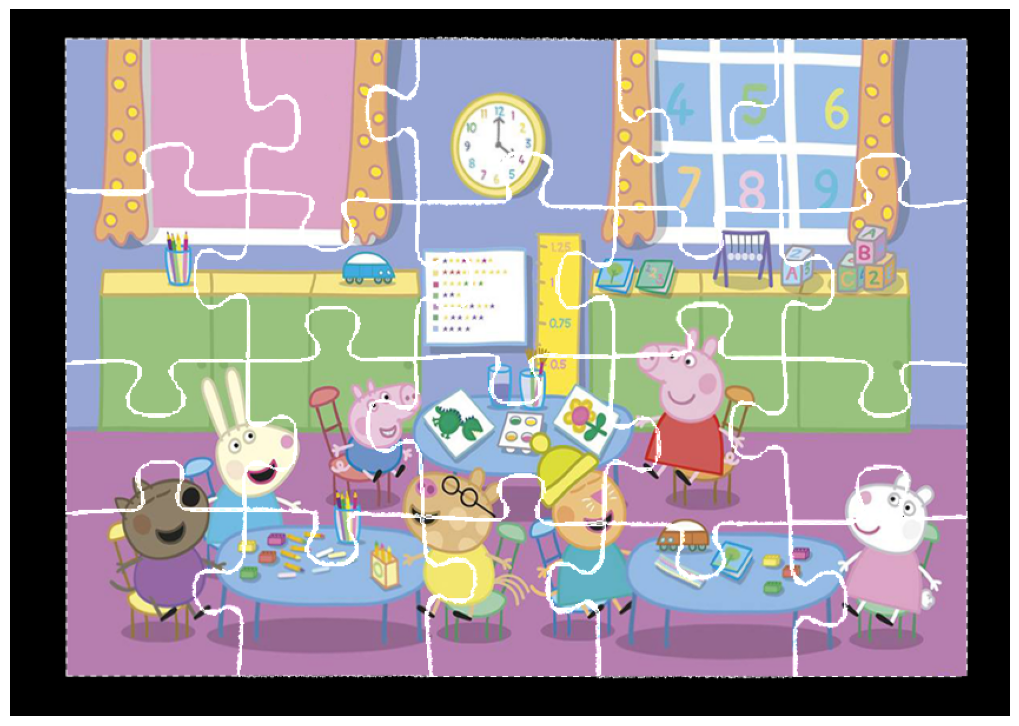

In [30]:
ReconPuzzle = np.zeros_like(Ref)

# Apply the Transforms
for i, Trns in enumerate(AffineTransforms):
    if Trns is not None:
        h, w = Pieces[i].shape[:2]

        WarpedPiece = cv.warpAffine(Pieces[i], Trns, (Ref.shape[1], Ref.shape[0]))
        Msk = np.where(WarpedPiece > 0, 1, 0).astype(np.uint8)
        ReconPuzzle = cv.add(ReconPuzzle, WarpedPiece * Msk)

# Final Puzzle
ImShow(ReconPuzzle)

## Puzzle Reconstruction with Alpha Blending

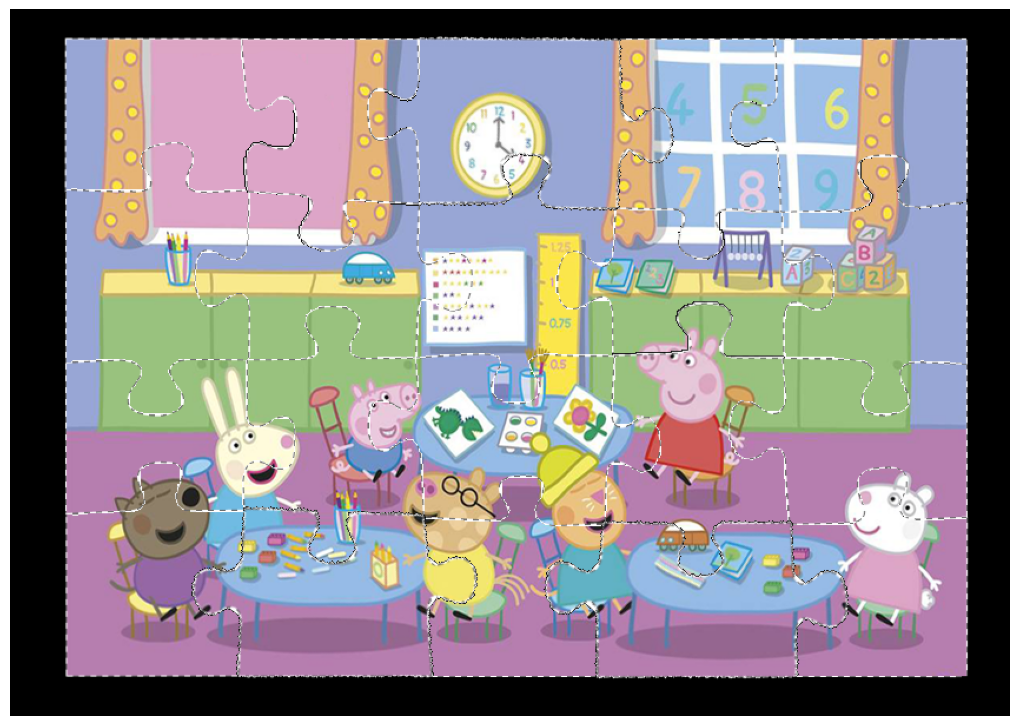

In [31]:
ReconPuzzle = np.zeros_like(Ref)

# Apply the Transforms
for i, Trns in enumerate(AffineTransforms):
    if Trns is not None:
        h, w = Pieces[i].shape[:2]

        WarpedPiece = cv.warpAffine(Pieces[i], Trns, (Ref.shape[1], Ref.shape[0]))
        Msk = np.where(WarpedPiece > 0, 1, 0).astype(np.uint8)

        # Perform Alpha Blending
        region = ReconPuzzle * (1 - Msk) 
        blended_piece = cv.addWeighted(region, 1, WarpedPiece, 1, 0)
        ReconPuzzle = blended_piece

# Final Puzzle
ImShow(ReconPuzzle)
